In [2]:
from os import listdir
from os.path import isfile, join

import ast

import json

import networkx as nx

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np

%matplotlib inline

In [18]:
def input_networkx_graph_from_file(path: str) -> nx.Graph:
    G = nx.Graph()
    with open(path, 'r') as f:
        for line in f.readlines()[1:]:
            name, size, *children = map(int, line.strip().split())
            name = int(name)
            children = list(map(int, children))
            G.add_node(name, weight=size)
            G.add_edges_from((name, child) for child in children)
    G.graph['node_weight_attr'] = 'weight'
    
    return G

In [19]:
# * МЕТИС-взвеш
# * МЕТИС-невзвеш
#   * ВНИМАНИЕ! Нач.разбиение от МЕТИСа (взвеш, невзвеш) раскладываем по процессорам так, что самая тяжелая группа идет на самый быстрый процессор, и т.п. по убыванию веса групп и произв-ти процессоров.
# * ЖА-обычн от МЕТИС-взвеш
# * ЖА-обычн от МЕТИС-невзвеш
# * Генетика старая от МЕТИС-взвеш (мин, макс)
# * Генетика старая от МЕТИС-невзвеш (мин, макс)
# * Генетика новая от МЕТИС-взвеш (мин, макс)
# * Генетика новая от МЕТИС-невзвеш (мин, макс)
# * ПЖ_МК
# * ПЖ_МК_CR+

./results/GAP_metis/weighted/rand/dag26.txt
./results/GAP_metis/unweighted/rand/dag26.txt
./results/GAP2_metis/weighted/rand/dag26.txt
./results/GAP2_metis/unweighted/rand/dag26.txt


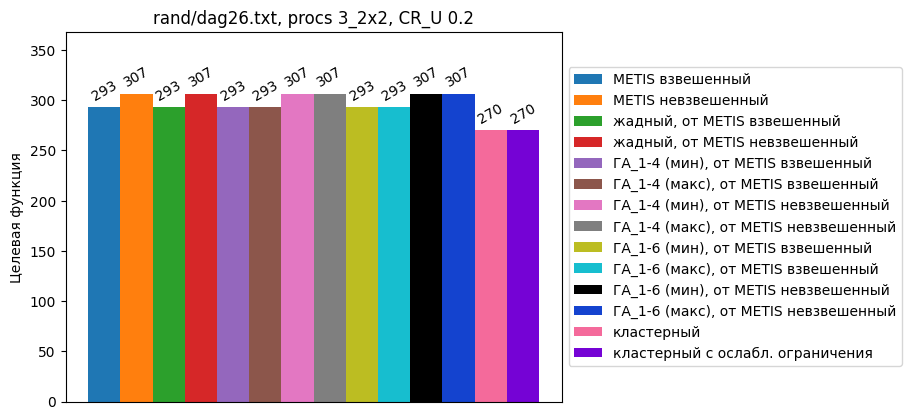

[293.33333333 306.66666667 293.33333333 306.66666667 293.33333333
 293.33333333 306.66666667 306.66666667 293.33333333 293.33333333
 306.66666667 306.66666667 270.         270.        ]


In [ ]:
graph_name = 'triangle/triadag10_5.txt'
graph_name = 'sausages/dagA15.txt'
# graph_name = 'testing_graphs/16_envelope_mk_rand.txt'
# graph_name = 'testing_graphs/16_envelope_mk_eq.txt'
graph_name = 'rand/dag26.txt'

# pg_name = '3_2x1.txt'
pg_name = '3_2x2.txt'
# pg_name = '3_2x3.txt'
# pg_name = '3_2x4.txt'
# pg_name = '3_2x5.txt'
# pg_name = '1_4x1.txt'
# pg_name = '1_4x2.txt'
# pg_name = '1_4x3.txt'
# pg_name = '1_4x4.txt'
# pg_name = '1_4x5.txt'
# pg_name = '5_4_3_2x1.txt'
# pg_name = '5_4_3_2x2.txt'
# pg_name = '5_4_3_2x3.txt'
# pg_name = '5_4_3_2x4.txt'
# pg_name = '5_4_3_2x5.txt'


cr_u = 0.35
# cr_u = 0.2
cr_u = 0.4
# cr_u = 0.45
iter_u = 100
# iter_u = 50
# cr_u = 0.3
# cr_u = 0.45
# cr_u = 0.4
cr_u = 0.2

# cr_u_list = [0.2, 0.3, 0.4]

bars = []

names = [
    'METIS взвешенный',
    'METIS невзвешенный',
    'жадный, от METIS взвешенный',
    'жадный, от METIS невзвешенный',
    'ГА_1-4 (мин), от METIS взвешенный',
    'ГА_1-4 (макс), от METIS взвешенный',
    'ГА_1-4 (мин), от METIS невзвешенный',
    'ГА_1-4 (макс), от METIS невзвешенный',
    'ГА_1-6 (мин), от METIS взвешенный',
    'ГА_1-6 (макс), от METIS взвешенный',
    'ГА_1-6 (мин), от METIS невзвешенный',
    'ГА_1-6 (макс), от METIS невзвешенный',
    'кластерный',
    'кластерный с ослабл. ограничения',
]

# for cr_u in cr_u_list:
paths = [
    './results2/metis_with_pg/weighted/{}',
    './results2/metis_with_pg/unweighted/{}',
    './results/greed/weighted/{}',
    './results/greed/unweighted/{}',
]
for path in paths:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        for line in file.readlines():
            _, pg, _, cr, cr_lim, f_val, _ = line.split(maxsplit=6)
            # cr = float(cr)
            cr_lim = float(cr_lim)
            f_val = float(f_val)

            if pg_name == pg and cr_u == cr_lim:
                bars.append(f_val)
                break

paths_genetics = [
    './results/GAP_metis/weighted/{}',
    './results/GAP_metis/unweighted/{}',
    './results/GAP2_metis/weighted/{}',
    './results/GAP2_metis/unweighted/{}',
]
for path in paths_genetics:
    g_min = 1e12
    g_max = 0
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            _, pg, r2, max_iter, cr, _, cr_lim, f_val, _ = line.split(maxsplit=8)
            # cr = float(cr)
            max_iter = int(max_iter)
            cr_lim = float(cr_lim)
            f_val = float(f_val)

            if pg_name == pg and cr_u == cr_lim and iter_u == max_iter:
                # print(f_val)
                g_min = min(g_min, f_val)
                g_max = max(g_max, f_val)

        bars.append(g_min)
        bars.append(g_max)

paths = [
    './results2/MK_greed_greed_weighted/weighted/{}',
    './results2/MK_greed_greed_with_geq_cr/weighted/{}',
]
for path in paths:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        for line in file.readlines():
            _, pg, _, cr, cr_lim, f_val, _ = line.split(maxsplit=6)
            # cr = float(cr)
            cr_lim = float(cr_lim)
            f_val = float(f_val)

            if pg_name == pg and cr_u == cr_lim:
                bars.append(f_val)
                break

x = np.arange(len(bars))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

bars = np.array(bars)
if 'rand' in graph_name:
    bars = (bars / 16384) * 10

fig, ax = plt.subplots()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000', '#1443cf', '#f46a9b', '#7503d5']

for attribute, measurement, color in zip(names, bars, colors):
    offset = width * multiplier
    rects = ax.bar(offset, measurement, width, label=attribute, color=color)
    ax.bar_label(rects, padding=3, rotation=30, fmt='%.0f')
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Целевая функция')
# ax.set_title(f'{graph_name.strip(".txt").split("/")[-1]}')
# ax.set_title(f'{graph_name.replace("sausages", "layered")}, procs {pg_name.strip(".txt")}, CR_U {cr_u}')
# ax.set_title(f'{graph_name.replace("sausages", "layered")}, procs {pg_name.strip(".txt")}, CR_U {cr_u}, ITER_MAX {iter_u}')
ax.set_title(f'{graph_name.replace("sausages", "layered")}, procs {pg_name.removesuffix(".txt")}, CR_U {cr_u}')
# ax.set_xticks(x + width, species)
ax.set_xticks([])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, int(max(filter(lambda x: x < 1e7, bars))*1.2))
plt.show()

print(bars)

./results/GAP_metis/weighted/sausages/dagA15.time
./results/GAP_metis/unweighted/sausages/dagA15.time
./results/GAP2_metis/weighted/sausages/dagA15.time
./results/GAP2_metis/unweighted/sausages/dagA15.time
./results2/MK_greed_greed_weighted/weighted/sausages/dagA15.time
./results2/MK_greed_greed_with_geq_cr/weighted/sausages/dagA15.time


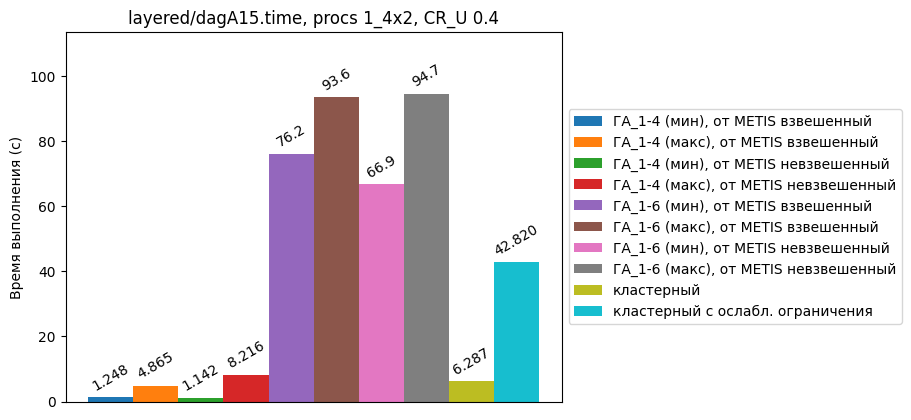

[ 1.24815536  4.86521649  1.14205074  8.21649432 76.18079948 93.566746
 66.87251854 94.70639682  6.28667283 42.82017159]


In [21]:
graph_name = 'sausages/dagA15.time'
# graph_name = 'triangle/triadag10_5.time'

# pg_name = '5_4_3_2x5.txt'
pg_name = '1_4x2.txt'


# cr_u = 0.35
cr_u = 0.4
iter_u = 100


bars = []

names = [
    'ГА_1-4 (мин), от METIS взвешенный',
    'ГА_1-4 (макс), от METIS взвешенный',
    'ГА_1-4 (мин), от METIS невзвешенный',
    'ГА_1-4 (макс), от METIS невзвешенный',
    'ГА_1-6 (мин), от METIS взвешенный',
    'ГА_1-6 (макс), от METIS взвешенный',
    'ГА_1-6 (мин), от METIS невзвешенный',
    'ГА_1-6 (макс), от METIS невзвешенный',
    'кластерный',
    'кластерный с ослабл. ограничения',
]


paths_genetics = [
    './results/GAP_metis/weighted/{}',
    './results/GAP_metis/unweighted/{}',
    './results/GAP2_metis/weighted/{}',
    './results/GAP2_metis/unweighted/{}',
]
for path in paths_genetics:
    g_min = 1e12
    g_max = 0
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            _, pg, cr_lim, start_time, time = line.split()
            # cr = float(cr)
            # max_iter = int(max_iter)
            cr_lim = float(cr_lim)
            time = float(time)

            if pg_name == pg and cr_u == cr_lim:
                # print(f_val)
                g_min = min(g_min, time)
                g_max = max(g_max, time)

        bars.append(g_min)
        bars.append(g_max)

paths = [
    './results2/MK_greed_greed_weighted/weighted/{}',
    './results2/MK_greed_greed_with_geq_cr/weighted/{}',
]
for path in paths:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        # dagA15.txt 5_4_3_2x5.txt 0.35 50 1716295898.9507778 0.16112923622131348 
        for line in file.readlines():
            _, pg, cr_lim, n, start_time, time = line.split()
            cr_lim = float(cr_lim)
            time = float(time)

            if pg_name == pg and cr_u == cr_lim:
                bars.append(time)
                break

x = np.arange(len(bars))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

# bars = list(map(lambda x: round(x, 1) if x > 100 else x, bars))

bars = np.array(bars)
if 'rand' in graph_name:
    bars = (bars / 16384) * 10

fig, ax = plt.subplots()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000', '#1443cf', '#f46a9b', '#7503d5']

for attribute, measurement, color in zip(names, bars, colors):
    offset = width * multiplier
    rects = ax.bar(offset, measurement, width, label=attribute, color=color)
    fmt = '%.3f' if measurement < 60 else '%.1f'
    ax.bar_label(rects, padding=3, rotation=30, fmt=fmt)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Время выполнения (с)')
ax.set_title(f'{graph_name.replace("sausages", "layered")}, procs {pg_name.strip(".txt")}, CR_U {cr_u}')
ax.set_xticks([])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
ax.set_ylim(0, max(bars)*1.2)
plt.show()

print(bars)

./results/greed/weighted/{}
./results/greed/weighted/rand/dag26.time
./results/greed/weighted/{}
./results/greed/weighted/rand/dag15.time
./results/greed/weighted/{}
./results/greed/weighted/rand/dag16.time
./results/greed/weighted/{}
./results/greed/weighted/rand/dag13.time
./results/greed/weighted/{}
./results/greed/weighted/rand/dag0.time
[0.0008645057678222656, 0.0014007091522216797, 0.0026276111602783203, 0.001932382583618164, 0.002126455307006836]
./results2/MK_greed_greed_weighted/weighted/rand/dag26.time
./results2/MK_greed_greed_weighted/weighted/rand/dag15.time
./results2/MK_greed_greed_weighted/weighted/rand/dag16.time
./results2/MK_greed_greed_weighted/weighted/rand/dag13.time
./results2/MK_greed_greed_weighted/weighted/rand/dag0.time
[1.4194881916046143, 3.4700284004211426, 6.405776739120483, 8.710006952285767, 11.681722402572632]
./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag26.time
./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag15.time
./results2/MK_gree

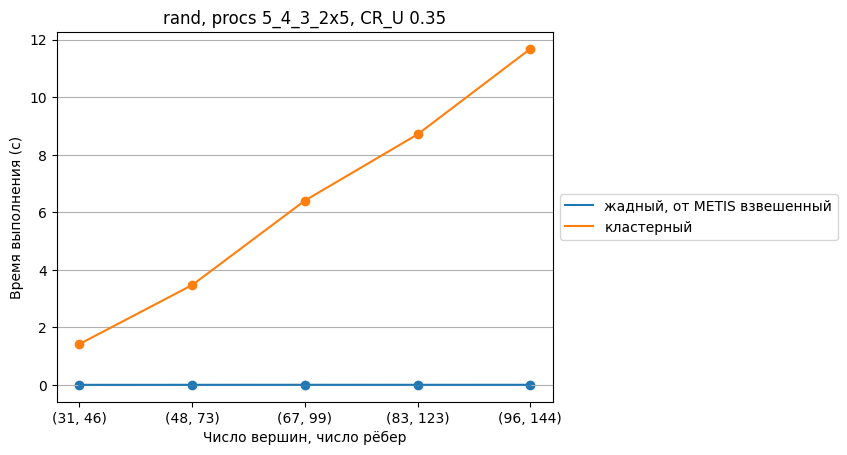

In [ ]:
graphs = [
    # 'testing_graphs/16_envelope_mk_eq.time',
    # 'testing_graphs/16_envelope_mk_rand.time',
    # 'testing_graphs/64_envelope_mk_eq.time',
    # 'testing_graphs/64_envelope_mk_rand.time',
    'rand/dag26.time',
    'rand/dag15.time',
    'rand/dag16.time',
    'rand/dag13.time',
    'rand/dag0.time',
    # 'sausages/dagA15.time',
    # 'sausages/dagH28.time',
    # 'sausages/dagK43.time',
    # 'sausages/dagN19.time',
    # 'sausages/dagR49.time',
    # 'triangle/triadag10_5.time',
    # 'triangle/triadag15_4.time',
    # 'triangle/triadag20_5.time',
    # 'triangle/triadag25_0.time',
    # 'triangle/triadag30_7.time',
]

# paths = [
#     './results/greed/weighted/{}',
#     './results2/MK_greed_greed_weighted/weighted/{}',
#     './results2/MK_greed_greed_with_geq_cr/weighted/{}',
# ]

labels = []
y = []


pg_name = '5_4_3_2x5.txt'
# pg_name = '1_4x2.txt'


cr_u = 0.35
# cr_u = 0.4

greed_y = []
greed_x = []
path = './results/greed/weighted/{}'
for graph_name in graphs:
    print(path)
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            # triadag10_5.txt 5_4_3_2x5.txt 0.35 55 1716289529.4229527 1.0220365524291992
            _, pg, cr_lim, n, start_time, time = line.split()
            # cr = float(cr)
            # max_iter = int(max_iter)
            n = int(n)
            cr_lim = float(cr_lim)
            time = float(time)

            if pg_name == pg and cr_u == cr_lim:
                greed_y.append(time)
        
                graph_path = f'./data/{graph_name}'.replace('triangle', 'triangle/graphs').replace('.time', '.txt')
                g = input_networkx_graph_from_file(graph_path)
                
                greed_x.append((n, len(g.edges)))
                break


x = np.arange(len(greed_x))  # the label locations

fig, ax = plt.subplots()
ax.plot(x, greed_y, label='жадный, от METIS взвешенный')
ax.scatter(x, greed_y)
print(greed_y)


MK_greed_greed_weighted_y = []
MK_greed_greed_weighted_x = []
path = './results2/MK_greed_greed_weighted/weighted/{}'
for graph_name in graphs:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            # triadag10_5.txt 5_4_3_2x5.txt 0.35 55 1716289529.4229527 1.0220365524291992
            _, pg, cr_lim, n, start_time, time = line.split()
            # cr = float(cr)
            # max_iter = int(max_iter)
            n = int(n)
            cr_lim = float(cr_lim)
            time = float(time)

            if pg_name == pg and cr_u == cr_lim:
                MK_greed_greed_weighted_x.append(n)
                MK_greed_greed_weighted_y.append(time)
                break

# fig, ax = plt.subplots()
ax.plot(x, MK_greed_greed_weighted_y, label='кластерный')
ax.scatter(x, MK_greed_greed_weighted_y)

print(MK_greed_greed_weighted_y)




MK_greed_greed_with_geq_cr_y = []
MK_greed_greed_with_geq_cr_x = []
path = './results2/MK_greed_greed_with_geq_cr/weighted/{}'
for graph_name in graphs:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            # triadag10_5.txt 5_4_3_2x5.txt 0.35 55 1716289529.4229527 1.0220365524291992
            _, pg, cr_lim, n, start_time, time = line.split()
            # cr = float(cr)
            # max_iter = int(max_iter)
            n = int(n)
            cr_lim = float(cr_lim)
            time = float(time)

            if pg_name == pg and cr_u == cr_lim:
                MK_greed_greed_with_geq_cr_x.append(n)
                MK_greed_greed_with_geq_cr_y.append(time)
                break

# ax.plot(x, MK_greed_greed_with_geq_cr_x, label='кластерный с ослабл. ограничения')
# ax.scatter(x, MK_greed_greed_with_geq_cr_x)

print(MK_greed_greed_with_geq_cr_x)



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Время выполнения (с)')
ax.set_title(f'{graph_name.replace("sausages", "layered").split("/")[0]}, procs {pg_name.removesuffix(".txt")}, CR_U {cr_u}')
ax.set_xlabel('Число вершин, число рёбер')
plt.xticks(x, greed_x) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
ax.grid(axis='y')
# ax.set_ylim(-20, 510)
plt.show()

./results2/MK_greed_greed_weighted/weighted/rand/dag26.time
./results2/MK_greed_greed_weighted/weighted/rand/dag15.time
./results2/MK_greed_greed_weighted/weighted/rand/dag16.time
./results2/MK_greed_greed_weighted/weighted/rand/dag13.time
./results2/MK_greed_greed_weighted/weighted/rand/dag0.time
./results2/MK_greed_greed_weighted/weighted/sausages/dagA15.time
./results2/MK_greed_greed_weighted/weighted/sausages/dagH28.time
./results2/MK_greed_greed_weighted/weighted/sausages/dagK43.time
./results2/MK_greed_greed_weighted/weighted/sausages/dagN19.time
./results2/MK_greed_greed_weighted/weighted/sausages/dagR49.time
./results2/MK_greed_greed_weighted/weighted/triangle/triadag10_5.time
./results2/MK_greed_greed_weighted/weighted/triangle/triadag15_4.time
./results2/MK_greed_greed_weighted/weighted/triangle/triadag20_5.time
./results2/MK_greed_greed_weighted/weighted/triangle/triadag25_0.time
./results2/MK_greed_greed_weighted/weighted/triangle/triadag30_7.time
[1.4194881916046143, 3.470

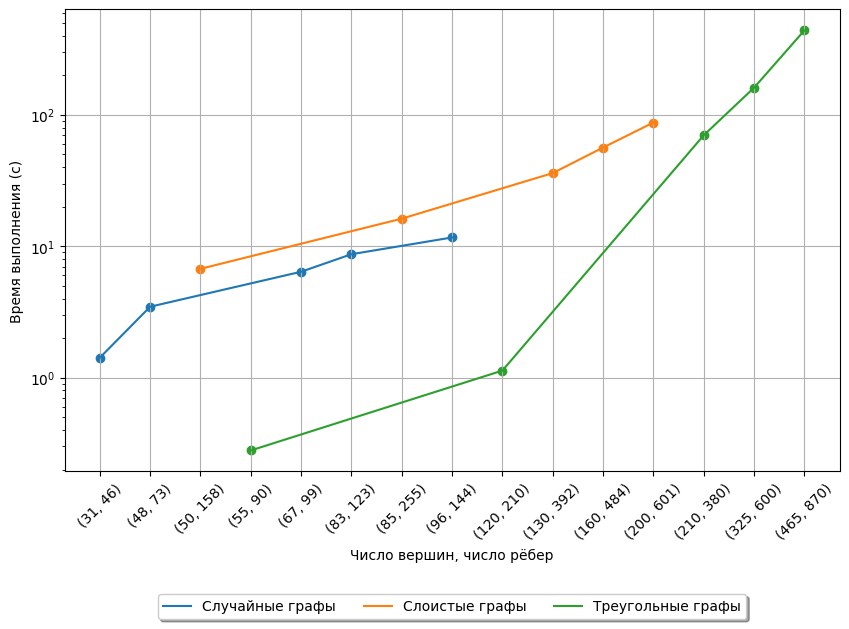

In [125]:
graphs = [
    # 'testing_graphs/16_envelope_mk_eq.time',
    # 'testing_graphs/16_envelope_mk_rand.time',
    # 'testing_graphs/64_envelope_mk_eq.time',
    # 'testing_graphs/64_envelope_mk_rand.time',
    'rand/dag26.time',
    'rand/dag15.time',
    'rand/dag16.time',
    'rand/dag13.time',
    'rand/dag0.time',
    'sausages/dagA15.time',
    'sausages/dagH28.time',
    'sausages/dagK43.time',
    'sausages/dagN19.time',
    'sausages/dagR49.time',
    'triangle/triadag10_5.time',
    'triangle/triadag15_4.time',
    'triangle/triadag20_5.time',
    'triangle/triadag25_0.time',
    'triangle/triadag30_7.time',
]

# paths = [
#     './results/greed/weighted/{}',
#     './results2/MK_greed_greed_weighted/weighted/{}',
#     './results2/MK_greed_greed_with_geq_cr/weighted/{}',
# ]

labels = []
y = []

pg_name = '5_4_3_2x5.txt'

cr_u = 0.35



fig, ax = plt.subplots(figsize=(10,6))

all_x = []
first_x = []

MK_greed_greed_weighted_y = []
MK_greed_greed_weighted_x = []
path = './results2/MK_greed_greed_weighted/weighted/{}'
for graph_name in graphs:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            # triadag10_5.txt 5_4_3_2x5.txt 0.35 55 1716289529.4229527 1.0220365524291992
            _, pg, cr_lim, n, start_time, time = line.split()
            # cr = float(cr)
            # max_iter = int(max_iter)
            n = int(n)
            cr_lim = float(cr_lim)
            time = float(time)

            if pg_name == pg and cr_u == cr_lim:
                graph_path = f'./data/{graph_name}'.replace('triangle', 'triangle/graphs').replace('.time', '.txt')
                g = input_networkx_graph_from_file(graph_path)
                
                labels.append((n, len(g.edges)))

                MK_greed_greed_weighted_x.append(n)
                MK_greed_greed_weighted_y.append(time)
                break

# fig, ax = plt.subplots()

print(MK_greed_greed_weighted_y)

labels.sort(key=lambda _: _[1])
labels.sort(key=lambda _: _[0])

# labels = np.array(labels)

x = np.arange(len(labels))  # the label locations
labels = np.array(labels)
print(labels[:, 0])
print('---')
print(labels)
print(MK_greed_greed_weighted_y[:5])
ax.plot(x[np.isin(labels[:, 0], MK_greed_greed_weighted_x[:5])], MK_greed_greed_weighted_y[:5], label='Случайные графы')
ax.scatter(x[np.isin(labels[:, 0], MK_greed_greed_weighted_x[:5])], MK_greed_greed_weighted_y[:5])

ax.plot(x[np.isin(labels[:, 0], MK_greed_greed_weighted_x[5:10])], MK_greed_greed_weighted_y[5:10], label='Слоистые графы')
ax.scatter(x[np.isin(labels[:, 0], MK_greed_greed_weighted_x[5:10])], MK_greed_greed_weighted_y[5:10])

ax.plot(x[np.isin(labels[:, 0], MK_greed_greed_weighted_x[10:15])], MK_greed_greed_weighted_y[10:15], label='Треугольные графы')
ax.scatter(x[np.isin(labels[:, 0], MK_greed_greed_weighted_x[10:15])], MK_greed_greed_weighted_y[10:15])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Время выполнения (с)')
# ax.set_title(f'{graph_name.replace("sausages", "layered").split("/")[0]}, procs {pg_name.strip(".txt")}, CR_U {cr_u}')
ax.set_xlabel('Число вершин, число рёбер')
plt.xticks(x, map(tuple, labels), rotation=45)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=5)   
ax.grid(axis='both')
# ax.set_ylim(-20, 510)
# ax.set_yscale('log')
plt.show()

In [147]:
greed_results_dir = './results/greed/weighted/gen_data'
mk_results_dir = './results2/MK_greed_greed_weighted/weighted/gen_data'

# heatmap_greed = []
graph_data = dict()
greed_data = defaultdict(dict)
for graph in listdir(greed_results_dir):
    try:
        if not graph.endswith('.graph'):
            raise NameError()

        proc_prefix, L, min_l, max_l, N, cr_gen, shuffle = graph.removesuffix('.graph').rsplit('_', maxsplit=6)
        L, min_l, max_l, N, cr_gen = int(L), int(min_l), int(max_l), float(N), float(cr_gen)
        
        if shuffle not in ['True', 'False']:
            raise NameError()
        
        shuffle = True if shuffle == True else False
    except Exception as e:
        print(f'Что-то не то {e}')
        continue
    
    # if not graph.startswith('0_'):
        # continue
    # else:
        # print('!!!!!!!!11')
    
    graph_data[graph] = L
    with open(join(greed_results_dir, graph), 'r') as f:
        for line in f.readlines():
            try:
                g, pg, cr_fact, cr_max, f_val, partition = line.split(maxsplit=5)
                
                pg = pg.removesuffix('.txt').split('x')
                pg_prefix = (pg[0] + '_') * int(pg[1])
                
                cr_fact, cr_max, f_val = float(cr_fact), float(cr_max), float(f_val)

                if '[' not in partition:
                    continue

                partition = ast.literal_eval(partition)
                
                if g != graph:
                    raise NameError(f'имя файла {g} != строчке в файле {graph}')
                
                # print('<--', graph.removeprefix(pg_prefix).removesuffix('.graph').split('_'))
                L, min_l, max_l, N, cr_gen, shuffle = graph.removeprefix(pg_prefix).removesuffix('.graph').split('_')
                L, min_l, max_l, N, cr_gen = int(L), int(min_l), int(max_l), float(N), float(cr_gen)
                if shuffle not in ['True', 'False']:
                    raise NameError()
            
            except Exception as e:
                print('->', e)
                continue
            
            greed_data[graph][cr_max] = (cr_fact, f_val)

mk_data = defaultdict(dict)
for graph in listdir(mk_results_dir):
    try:
        if not graph.endswith('.graph'):
            raise NameError()

        proc_prefix, L, min_l, max_l, N, cr_gen, shuffle = graph.removesuffix('.graph').rsplit('_', maxsplit=6)
        L, min_l, max_l, N, cr_gen = int(L), int(min_l), int(max_l), float(N), float(cr_gen)
        
        if shuffle not in ['True', 'False']:
            raise NameError()
        
        shuffle = True if shuffle == True else False
    except Exception as e:
        print(f'Что-то не то {e}')
        continue
    
    # if graph != '3_2_3_2_3_2_3_2_3_2_3000_10_100_1.6_0.1_False.graph':
        # continue
    with open(join(mk_results_dir, graph), 'r') as f:
        for line in f.readlines():
            try:
                g, pg, cr_fact, cr_max, f_val, partition = line.split(maxsplit=5)
                
                pg = pg.removesuffix('.txt').split('x')
                pg_prefix = (pg[0] + '_') * int(pg[1])
                
                cr_fact, cr_max, f_val = float(cr_fact), float(cr_max), float(f_val)

                if '[' not in partition:
                    continue

                partition = ast.literal_eval(partition)
                
                if g != graph:
                    raise NameError(f'имя файла {g} != строчке в файле {graph}')
                
                # print('<--', graph.removeprefix(pg_prefix).removesuffix('.graph').split('_'))
                L, min_l, max_l, N, cr_gen, shuffle = graph.removeprefix(pg_prefix).removesuffix('.graph').split('_')
                L, min_l, max_l, N, cr_gen = int(L), int(min_l), int(max_l), float(N), float(cr_gen)
                if shuffle not in ['True', 'False']:
                    raise NameError()
            
            except Exception as e:
                # print('->', e)
                continue
            
            mk_data[graph][cr_max] = (float(cr_fact), float(f_val))
greed_data, mk_data

-> could not convert string to float: 'None'
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 
Что-то не то 


(defaultdict(dict,
             {'3_2_3_2_3_2_3_2_3_2_1000_10_100_2.0_0.6_False.graph': {0.1: (0.09956236323851203,
                7044.333333333333),
               0.15: (0.14660831509846828, 6649.666666666667),
               0.2: (0.19912472647702406, 5483.333333333333),
               0.25: (0.24945295404814005, 5093.333333333333),
               0.3: (0.2975929978118162, 3915.0),
               0.35: (0.34573304157549234, 1455.6666666666667),
               0.4: (0.3993435448577681, 1057.5),
               0.45: (0.4234135667396061, 1014.0),
               0.5: (0.4234135667396061, 1014.0),
               0.55: (0.4234135667396061, 1014.0),
               0.6: (0.4234135667396061, 1014.0),
               0.65: (0.4234135667396061, 1014.0),
               0.7: (0.4234135667396061, 1014.0),
               0.8: (0.4234135667396061, 1014.0),
               0.9: (0.4234135667396061, 1014.0),
               1.0: (0.4234135667396061, 1014.0)},
              '4_1_4_1_4_1_4000_10_100_4.0

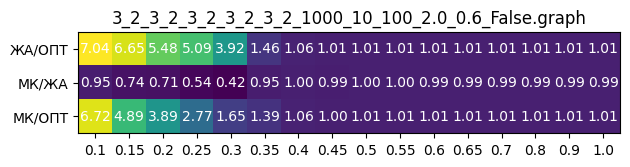

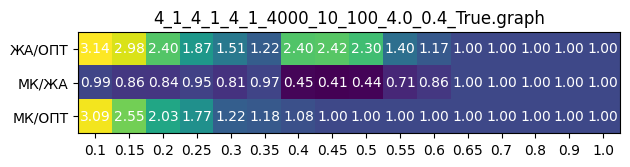

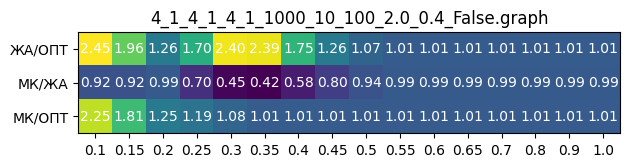

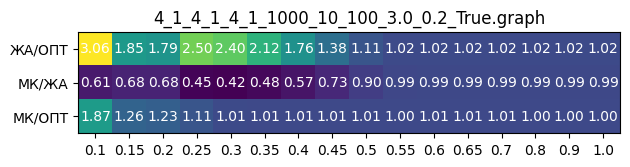

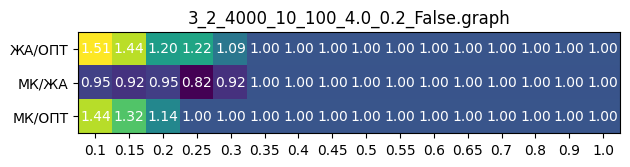

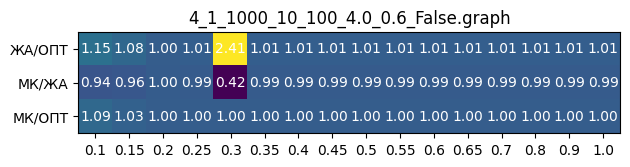

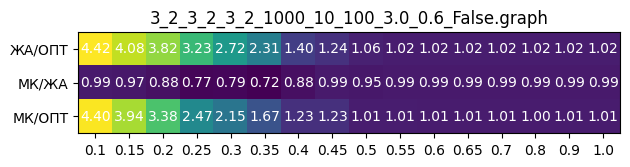

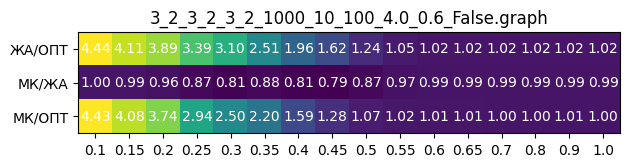

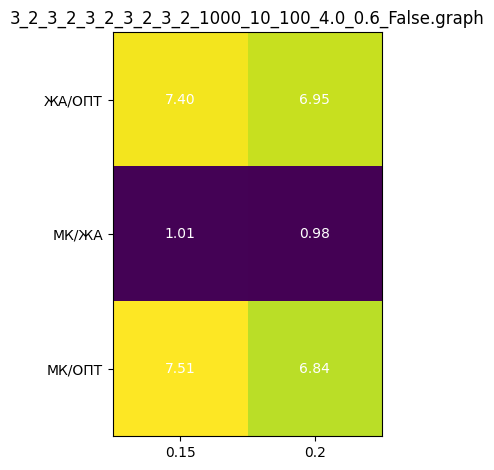

In [148]:
y_labels = [
    'ЖА/ОПТ',
    'МК/ЖА',
    'МК/ОПТ',
]
for graph in greed_data:
    cr_list = []
    heatmap = []
    greed_vals = []

    heat_line = []
    for cr_max, (cr_fact, f_val) in greed_data[graph].items():
        # print(f'./results/greed/weighted/gen_data/{graph}')
        # print('>', cr_max, f_val)
        heat_line.append((cr_max, f_val))
    
    cr_list = list(sorted(map(lambda x: x[0], heat_line)))
    heat_line = list(map(lambda x: x[1], sorted(heat_line, key=lambda x: x[0])))
    heat_line = np.array(heat_line)
    greed_vals = heat_line
    
    greed_vals = np.array(greed_vals, dtype=np.float64)
    heatmap.append(greed_vals / graph_data[graph])
    
    mk_vals = []
    heat_line = []
    for cr_max, (cr_fact, f_val) in mk_data[graph].items():
        # print(f'./results2/MK_greed_greed_weighted/weighted/gen_data/{graph}')
        # print(cr_max, f_val)
        heat_line.append((cr_max, f_val))
    heat_line = list(map(lambda x: x[1], sorted(heat_line, key=lambda x: x[0])))
    heat_line = np.array(heat_line)
    mk_vals = heat_line
    # print(mk_vals, greed_vals)
    try:
        # print('-', np.array(mk_vals))
        heatmap.append(np.divide(np.array(mk_vals), np.array(greed_vals)))
    except:
        continue
    heatmap.append(np.array(mk_vals) / graph_data[graph])

    
    heatmap = np.array(heatmap) 
    # heatmap /= np.max(heatmap)
    # print(heatmap[0])
    # print(heatmap)
    fig, ax = plt.subplots()
    im = ax.imshow(heatmap)
    
    ax.set_xticks(np.arange(len(cr_list)), labels=cr_list)
    ax.set_yticks(np.arange(len(y_labels)), labels=y_labels)
    
    # print(heatmap)
    
    for i in range(len(y_labels)):
        for j in range(len(cr_list)):
            # print(heatmap[i, j])
            text = ax.text(j, i, f'{heatmap[i, j]:.2f}', ha="center", va="center", color="w")
    
    ax.set_title(graph)
    fig.tight_layout()
    
    plt.show()
    
    # print(heatmap)
    # print(*heatmap, sep='\n')
    # break
    # if '5_4' in graph:
        # break

In [2]:
from helpers import input_generated_graph_and_processors_from_file

import matplotlib.lines as lines

./data/gen_data/4_1_4_1_4000_10_100_2.0_0.1_True.graph
[4, 1, 4, 1]
4931.0


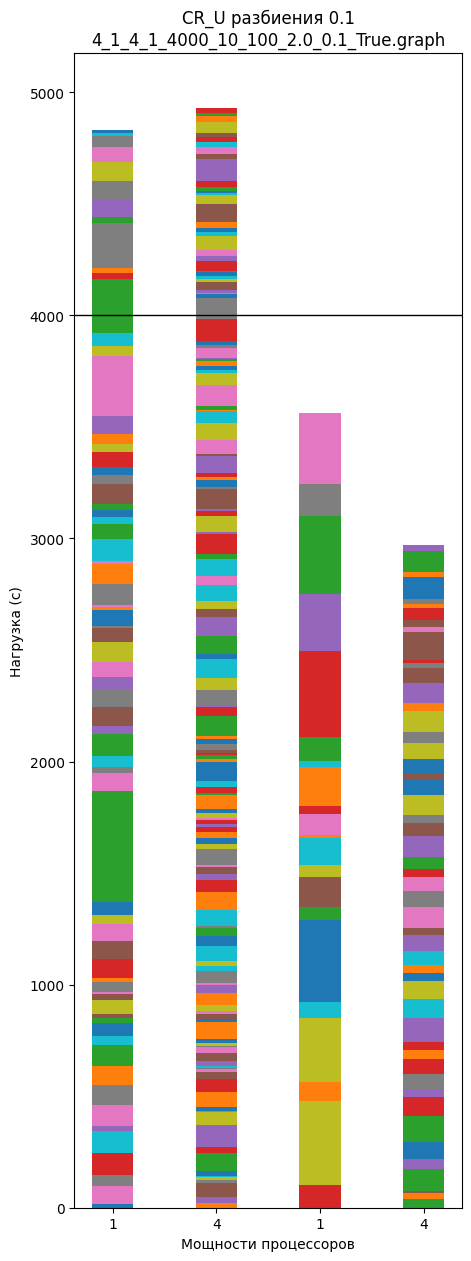

In [6]:
# graph_name = '4_1_4_1_4000_10_100_2.0_0.1_True.graph'
graph_name = '4_1_4_1_4000_10_100_2.0_0.1_True.graph'
graph_path = f'./data/gen_data/{graph_name}'
print(graph_path)
partition_path = f'./results/greed/weighted/gen_data/{graph_name}'
cr = ' 0.1 '
pg_name = ' 1_4x2.txt '

graph, p, graph_params = input_generated_graph_and_processors_from_file(graph_path)
with open(partition_path, 'r') as f:
    for line in f.readlines():
        if pg_name in line and cr in line and '[' in line:
            _, _, _, cr_fact, _, f_val, partiton = line.split(maxsplit=6)
            partiton = eval(partiton)
            # break


# pg_name = pg_name.strip().strip('.txt').split('x')
# p = sorted(map(int, pg_name[0].split('_'))) * int(pg_name[1]) 
bottom = [0] * len(p)
 
fig = plt.figure(figsize = (5, 15))
# ax1 = fig.add_subplot()

# creating the bar plot

# print(bottom)
# for i in range(len(p)):
for job_num, proc_num in enumerate(partiton):
    
    bar = [0] * len(p)
    bar[proc_num] += graph.nodes[job_num]['weight'] / p[proc_num]
    plt.bar(range(len(p)), bar, bottom=bottom, width=0.4)
    bottom[proc_num] += graph.nodes[job_num]['weight'] / p[proc_num]

plt.axhline(y=graph_params['L'], linewidth=1, color='k')
# plt.axhline(y=f_val, linewidth=1, color='r')
print(f_val)

plt.xlabel("Мощности процессоров")
plt.ylabel("Нагрузка (с)")
plt.xticks(range(len(p)), p)
# secax = fig.secondary_xaxis('top', functions=(deg2rad, rad2deg))
# ax2.set_xlim(fig.get_xlim())
# ax2 = ax1.twiny()
plt.title(f'CR_U разбиения {cr.strip()}\n' + graph_name)
plt.show()

In [130]:
path_greed_mk: str = './results2/MK_greed_greed_weighted/weighted/{}'
path_mk_geq_cr: str = './results2/MK_greed_greed_with_geq_cr/weighted/{}'
# path_greed_mk: str = './results2/MK_greed_greed_with_geq_cr/weighted/{}'
path_greed: str = './results/greed/weighted/{}'
# path_greed: str = './results/greed/weighted/{}'
path_simple: str = './results2/simple_part/weighted/{}'

# graph_name = 'triangle/triadag25_7.txt'
# graph_name = 'testing_graphs/16_envelope_mk_eq.txt'
# graph_name = 'testing_graphs/64_envelope_mk_eq.txt'
# graph_name = 'sausages/dagD39.txt' # 65 вершин
# graph_name = 'sausages/dagR62.txt' # 200 вершин
# graph_name = 'sausages/dagM5.txt'
# graph_name = 'sausages/dagP38.txt'
# graph_name = 'sausages/dagK43.txt'
# graph_name = 'sausages/dagE8.txt'
# graph_name = 'rand/dag26.txt'
# graph_name = 'triangle/triadag10_5.txt'
graph_name = 'gen_data/3_2_3_2_3_2_3_2_3_2_1000_10_100_2.0_0.6_False.graph'
# graph_name = 'testing_graphs/test.txt'
# graph_name = 'testing_graphs/test2.txt'

# ./results2/MK_greed_greed_with_geq_cr/weighted/testing_graphs/16_envelope_mk_eq.txt 64
# ./results2/MK_greed_greed_with_geq_cr/weighted/testing_graphs/64_envelope_mk_eq.txt 64
# ./results2/MK_greed_greed_with_geq_cr/weighted/testing_graphs/16_envelope_mk_eq.txt 64
# ./results2/MK_greed_greed_with_geq_cr/weighted/testing_graphs/16_envelope_mk_rand.txt 64
# ./results2/MK_greed_greed_with_geq_cr/weighted/sausages/dagA15.txt 50
# ./results2/MK_greed_greed_with_geq_cr/weighted/sausages/dagH28.txt 85
# ./results2/MK_greed_greed_with_geq_cr/weighted/sausages/dagK43.txt 130
# ./results2/MK_greed_greed_with_geq_cr/weighted/sausages/dagN19.txt 160
# ./results2/MK_greed_greed_with_geq_cr/weighted/sausages/dagR49.txt 200
# ./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag26.txt 31
# ./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag15.txt 48
# ./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag16.txt 67
# ./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag13.txt 83
# ./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag0.txt 96
# ./results2/MK_greed_greed_with_geq_cr/weighted/triangle/triadag10_5.txt 55
# ./results2/MK_greed_greed_with_geq_cr/weighted/triangle/triadag15_4.txt 120
# ./results2/MK_greed_greed_with_geq_cr/weighted/triangle/triadag20_5.txt 210
# ./results2/MK_greed_greed_with_geq_cr/weighted/triangle/triadag25_0.txt 325

# graph_name = 'triangle/triadag25_0.txt'


# path_greed = path_greed.format(graph_name)
# path_greed_mk = path_greed_mk.format(graph_name)
# path_simple = path_simple.format(graph_name)

In [131]:
paths = [
    path_greed.format(graph_name),
    path_greed_mk.format(graph_name),
    # path_mk_geq_cr.format(graph_name),
    path_simple.format(graph_name)
]

datas = [defaultdict(dict) for _ in range(len(paths))]

cr_set = set()
for path, data in zip(paths, datas):
    with open(path, 'r') as file:
        for line in file.readlines():
            line = line.strip()
            try:
                g_name, pg_name, cr, cr_lim, f_val, *_ = line.split()
                if g_name != graph_name.split('/')[-1]:
                    continue
                cr, cr_lim, f_val = float(cr), float(cr_lim), float(f_val)
            except:
                print(cr, cr_lim, f_val)
                continue

            pg_name = pg_name.removesuffix('.txt')
            pg_name = '_'.join(list(map(str, sorted(list(map(int, pg_name.split('x')[0].split('_'))), reverse=True)))) + 'x' + pg_name.split('x')[1]
            
            cr_set.add(cr_lim)
            data[pg_name][cr_lim] = float(f_val)

(
    greed_data, 
    # data_mk_geq_cr, 
    greed_mk_data, 
    simple_data 
) = datas

print(greed_mk_data)

defaultdict(<class 'dict'>, {'3_2x5': {0.1: 6716.333333333333, 0.15: 4892.666666666667, 0.2: 3885.6666666666665, 0.25: 2772.0, 0.3: 1650.6666666666667, 0.35: 1387.0, 0.4: 1057.5, 0.45: 1003.0, 0.5: 1011.0, 0.55: 1011.0, 0.6: 1007.0, 0.65: 1007.5, 0.7: 1008.0, 0.8: 1008.0, 0.9: 1008.0, 1.0: 1008.0}})


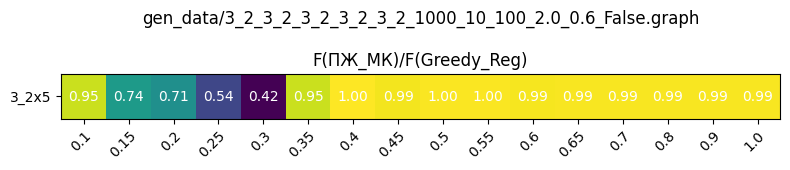

In [132]:
cr_list = sorted(list(cr_set))


pg_names0 = list(greed_mk_data.keys())

pgs = list(set(pg.split('x')[0] for pg in pg_names0))    

for pg in pgs:
    pg_names = filter(lambda x: x.startswith(pg) , pg_names0)
    pg_names = list(sorted(
        pg_names,
        key=lambda x: int(x.split('x')[1]),
        reverse=True,
    ))

    heats = [[] for _ in pg_names]
    simple = [[] for _ in pg_names]
    
    for i, pg_name in enumerate(pg_names):
        for cr in cr_list:
            heats[i].append(
                greed_mk_data[pg_name][cr] / greed_data[pg_name][cr]
            )

            simple[i].append(
                greed_mk_data[pg_name][cr] / simple_data[pg_name][cr]
            )
    
    heats = np.array(heats)
    simple = np.array(simple)
    
    fig, ax = plt.subplots(figsize=(len(cr_list)//2, len(pg_name)))
    # im = ax.imshow(heats, vmin=minimum_heat, vmax=maximum_heat)
    im = ax.imshow(heats)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(cr_list)), labels=cr_list)
    ax.set_yticks(np.arange(len(pg_names)), labels=pg_names)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(pg_names)):
        for j in range(len(cr_list)):
            val = f'{heats[i, j]:.2f}' if heats[i, j] > 0.001 else f'[{simple[i, j]:.2f}]'
            text = ax.text(j, i, f'{val}',
                           ha="center", va="center", color="w")
    
    # ax.set_title(f'F(Greedy_MC{"_CR+" if "1" in path_greed_mk else ""})/F(Greedy_Reg)\n\n' + graph_name.split('/')[-1])
    title = f'{graph_name}\n\n' + f'F(ПЖ_МК{"_CR+" if "geq_cr" in path_greed_mk else ""})/F(Greedy_Reg)'
    title = title.replace("sausages", "layered")
    ax.set_title(title)

    fig.tight_layout()
    plt.show()